# PCA Spectra

In [1]:
%matplotlib notebook
import numpy as np
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
from glob import glob
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from scipy import stats

import IPython

from matplotlib.animation import ArtistAnimation


%matplotlib inline
# All imports

from random import choice
from copy import copy
import time
from IPython import display
import math

In [2]:
eboss = Table.read('silo_eboss_detections-1.0.1.fits', 'DETECTIONS').to_pandas()

In [3]:
eboss.keys()

Index(['CATALOG_ID', 'EMLINE_SCAN_TYPE', 'DETECTION_Z', 'N_EMLINES_SN_GE4',
       'QUADATURE_SUM_SN_GE3', 'SPECTRA_GRADE', 'TOTAL_GRADE', 'COMMENT',
       'FIRST_DETECTION_FROM', 'FIRST_DETECTION_LG', 'SDSS_TARGET_NAME',
       'PLATE', 'MJD', 'FIBER_INDEX', 'SDSS_SURVEY', 'BESTOBJID', 'SPECOBJID',
       'CLASS_NOQSO', 'OBJCLASS', 'TARGET_GALAXY_TYPE', 'TARGETOBJID',
       'Z_NOQSO', 'ZERR_NOQSO', 'ZWARNING_NOQSO', 'RA', 'DEC', 'RA_HMS',
       'DEC_DMS', 'WAVE', 'FLUX', 'IVAR', 'AND_MASK', 'OR_MASK', 'SKY',
       'WDISP', 'MODEL_SILO', 'IVAR_RESCALED', 'RESIDUAL_FLUX',
       'SN_SPECTRA_SG'],
      dtype='object')

In [4]:
eboss2 = Table.read('silo_eboss_detections-1.0.1.fits', 'EMISSION_LINE_ANALYSIS')

In [5]:
eboss2.keys()


['DETECTION_CATALOG_ID',
 'NAME',
 'INDEX_IN_SPECTRA',
 'EM_WAVE',
 'SN',
 'GAUSS_FIT_REPORTED',
 'GAUSS_WAVE',
 'GAUSS_BASE_HEIGHT',
 'GAUSS_AMPLITUDE',
 'GAUSS_SIGMA',
 'RCHI2_SAMPLE',
 'NDOF_SAMPLE',
 'RCHI2_3SIG',
 'NDOF_3SIG',
 'SAMPLE_SIZE',
 'MODEL_WAVE_BASE',
 'GAUSS_MODEL',
 'FITTED_RESIDUAL_FLUX',
 'FITTED_IVAR_RESCALED',
 'AND_MASK',
 'OR_MASK']

In [6]:
#How about we exame a candidate that was confirmed by the BELLS survey
plate = 5004 #BOSS plate of the observation
mjd = 55711 #Modified julian day of observation
fiberid = 679 #Index of fiber on plate used to observe target
#image/[PLATE]/[IMAGE_TYPE]-[PLATE]-[MJD]-[FIBERID]-[SIZE].png

hdu = fits.open('silo_eboss_detections-1.0.1.fits')
index = np.where((hdu['DETECTIONS'].data['PLATE'] == plate)
    & (hdu['DETECTIONS'].data['MJD'] == mjd)
    & (hdu['DETECTIONS'].data['FIBER_INDEX'] == fiberid))[0][0]
data_for_plate_mjd_fiberid = hdu['DETECTIONS'].data[index]
#data_for_plate_mjd_fiberid = hdu['DETECTIONS'].data


#Now how about we get data for an emission line, such as the spectra for the OII(b,a) Doublet
index_for_plate_mjd_fiberid =  np.where((hdu['EMISSION_LINE_ANALYSIS'].data['DETECTION_CATALOG_ID'] == data_for_plate_mjd_fiberid['CATALOG_ID']) & (hdu['EMISSION_LINE_ANALYSIS'].data['NAME'] == 'OII(b, a) doublet'))[0][0]
             
emline_for_plate_mjd_fiberid = hdu['EMISSION_LINE_ANALYSIS'].data[index_for_plate_mjd_fiberid]

#What is the signal to noise measured for this emission-line
print('Signal Noise =',emline_for_plate_mjd_fiberid['SN'])
        
# Lets pull out the detection redshift and the residual flux
z = data_for_plate_mjd_fiberid['DETECTION_Z']
print('Detection Redshift (Zb) = ', z)
wave_vector = data_for_plate_mjd_fiberid['WAVE']
residual_flux = data_for_plate_mjd_fiberid['RESIDUAL_FLUX']
print('Residual Flux = ', residual_flux)

Signal Noise = 18.645704
Detection Redshift (Zb) =  0.9492507
Residual Flux =  [ 4.5344915   2.4347887  -1.90658    ...  6.4561706  -0.34404516
 -7.178837  ]


In [6]:
#https://data.sdss.org/sas/dr16/eboss/spectro/lensing/silo/v5_13_0/v5_13_0/1.0.1/
spectraLines = Table.read('GalaxySpectralEmissionLines.csv').to_pandas()

In [7]:
absLines = Table.read('GalaxySpectraAbsorptionLines.csv').to_pandas()

In [7]:
absLines.shape

(8, 2)

In [8]:
waveLine = []
for item in spectraLines['Rest Wave'].values:
    waveLine.append(item)
waveLine = np.array(waveLine)

print(waveLine)

[1033.3   1215.67  1239.42  1305.53  1335.52  1397.61  1399.8   1545.86
 1640.4   1665.85  1857.41  1908.27  2326.    2439.5   2800.32  3346.79
 3426.85  3728.3   3798.976 3836.47  3889.    4072.3   4102.89  4341.68
 4364.436 4862.68  4960.295 5008.24  6302.046 6365.536 6549.86  6564.61
 6585.27  6707.89  6718.29  6732.67 ]


In [9]:
absLine = []
for item in absLines['Rest Wave'].values:
    absLine.append(item)
absLine = np.array(absLine)

print(absLine)

[3934.777 3969.588 4305.61  5176.7   5895.6   8500.36  8544.44  8664.52 ]


In [10]:
waveLineName_li = []
for item in spectraLines['Species'].values:
    waveLineName_li.append(item)
waveLineName = waveLineName_li.copy()
waveLineName = np.array(waveLineName)
print(waveLineName)

['OVI' 'Lyα' 'NV' 'OI' 'CII' 'SiIV' 'SiIV+OIV' 'CIV' 'HeII' 'OIII' 'AlIII'
 'CIII' 'CII' 'NeIV' 'MgII' 'NeV' 'NeVI' 'OII' 'Hθ' 'Hη' 'HeI' 'SII' 'Hδ'
 'Hγ' 'OIII' 'Hβ' 'OIII' 'OIII' 'OI' 'OI' 'NII' 'Hα' 'NII' 'Li' 'SII'
 'SII']


In [11]:
absLineName_li = []
for item in absLines['Species'].values:
    absLineName_li.append(item)
absLineName = absLineName_li.copy()
absLineName = np.array(absLineName)
print(absLineName)


['K' 'H' 'G' 'Mg' 'Na' 'CaII' 'CaII' 'CaII']


In [62]:
print(absLine[6])
absLineName[6]

8544.44


'CaII'

In [12]:
temp = [1000, 1033.11, 5008.4]
for j in range(len(temp)):
    for k in range(len(waveLine)):
        if ( math.isclose(waveLine[k], temp[j], abs_tol=1) ):
            print(temp[j])

1033.11
5008.4


In [38]:
eboss.keys()

Index(['CATALOG_ID', 'EMLINE_SCAN_TYPE', 'DETECTION_Z', 'N_EMLINES_SN_GE4',
       'QUADATURE_SUM_SN_GE3', 'SPECTRA_GRADE', 'TOTAL_GRADE', 'COMMENT',
       'FIRST_DETECTION_FROM', 'FIRST_DETECTION_LG', 'SDSS_TARGET_NAME',
       'PLATE', 'MJD', 'FIBER_INDEX', 'SDSS_SURVEY', 'BESTOBJID', 'SPECOBJID',
       'CLASS_NOQSO', 'OBJCLASS', 'TARGET_GALAXY_TYPE', 'TARGETOBJID',
       'Z_NOQSO', 'ZERR_NOQSO', 'ZWARNING_NOQSO', 'RA', 'DEC', 'RA_HMS',
       'DEC_DMS', 'WAVE', 'FLUX', 'IVAR', 'AND_MASK', 'OR_MASK', 'SKY',
       'WDISP', 'MODEL_SILO', 'IVAR_RESCALED', 'RESIDUAL_FLUX',
       'SN_SPECTRA_SG'],
      dtype='object')

In [13]:
flux_li = []

for item in eboss.sample(1551)['FLUX'].values:
    #print(item.shape)
    flux_li.append(item[:4500].reshape(1, item[:4500].shape[0]))
    #print(item.reshape(1, item.shape[0]).shape)
flux_sample = np.concatenate((flux_li))
X = flux_sample.copy()

In [ ]:
eboss2.sample

In [154]:
X

array([[-0.71425927,  2.2842515 ,  2.1397605 , ...,  0.2994419 ,
        -0.32471737,  0.43704438],
       [-2.0964677 ,  0.41497463,  2.5527327 , ...,  2.277243  ,
         0.9777414 ,  2.8799863 ],
       [ 0.05568407, -1.5113324 ,  4.96132   , ...,  0.6918955 ,
         2.596934  ,  3.5253932 ],
       ...,
       [ 0.1849453 , -3.775523  , -5.9477396 , ...,  1.7296324 ,
         1.696405  ,  2.0484984 ],
       [ 4.377988  ,  2.0543659 , -0.26917878, ...,  1.8163115 ,
         1.2646194 ,  1.5668497 ],
       [10.678245  ,  8.301344  ,  5.924906  , ..., -0.34030312,
         1.3054869 ,  2.4491544 ]], dtype=float32)

In [14]:
wave_li = []
for item in eboss['WAVE'].values:
    #print(item.shape)
    wave_li.append(item[:4500].reshape(1, item[:4500].shape[0]))
    #print(item.reshape(1, item.shape[0]).shape)
wave_sample = np.concatenate((wave_li))
wave = wave_sample.copy()

In [32]:
# plate_li = []
# for item in eboss['PLATE'].values:
#     #print(item.shape)
#     plate_li.append(item[:4500].reshape(1, item[:4500].shape[0]))
#     #print(item.reshape(1, item.shape[0]).shape)
# plate_sample = np.concatenate((plate_li))
# plate = plate_sample.copy()

plate_sample = []
for item in eboss['PLATE']:
    plate_sample.append(item)
plate = plate_sample.copy()

In [33]:
mjd_sample = []
for item in eboss['MJD']:
    mjd_sample.append(item)
mjd = mjd_sample.copy()

In [35]:
fiberid_sample = []
for item in eboss['FIBER_INDEX']:
    fiberid_sample.append(item)
fiberid = fiberid_sample.copy()

In [32]:
# restWave.shape

In [15]:
#Signal to noises
sigNoi = []
count=0
for item in eboss['SN_SPECTRA_SG'].values:
    sigNoi.append(item[:4500].reshape(1, item[:4500].shape[0]))
    #print(item.reshape(1, item.shape[0]).shape)
    count+=1
sigNoi_sample = np.concatenate((sigNoi))
sigNoi = sigNoi_sample.copy()
print(count)

1551


In [269]:
sigNoi.mean()

0.4021541

#### HDU2: EMISSION_LINE_ANALYSIS

In [16]:
#Signal to noises: Gaussian convolved signal-to-noise of emission-line
SN_sample = []
for item in eboss2['SN']:
    SN_sample.append(item)
SN = SN_sample.copy()


In [20]:
np.mean(SN)

4.594321

In [17]:
#NAME: Name of emission-line
name_sample = []
for item in eboss2['NAME']:
    name_sample.append(item)
name = name_sample.copy()

In [22]:
name[:100]

['OII(b, a) doublet',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'HIc',
 'HIb',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'HIc',
 'HIb',
 'OIIIb',
 'OIIIa',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'HIc',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'HIc',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'HIc',
 'HIb',
 'OIIIb',
 'OIIIa',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'HIc',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'HIc',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'HIc',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 'HIc',
 'Single Gauss of OII(b, a)',
 'OII(b, a) doublet',
 'HId',
 '

In [18]:
#Index in Spectra: Index where emission-line is located in spectra
idx_sp_sample = []
for item in eboss2['INDEX_IN_SPECTRA']:
    idx_sp_sample.append(item)
idx_sp = idx_sp_sample.copy()

In [104]:
idx_sp[:10]

[4374, 4374, 3389, 3805, 4050, 4542, 3389, 4190, 4606, 4190]

In [91]:
np.mean(SN)

4.594321

In [92]:
SN[:10]

[6.6698523,
 6.6698523,
 9.1318,
 0.0,
 0.63107604,
 1.645937,
 9.1318,
 7.4631968,
 0.0,
 7.4631968]

In [106]:
sigNoi_mean.min(), sigNoi_mean.max()

(0.3366343, 0.63691914)

In [266]:
sigNoi_mean.mean()

0.402154

In [19]:
sigNoi_mean = []
for i in range(1551):
    sigNoi_mean.append(np.mean(sigNoi[i]))
sigNoi_mean = np.array(sigNoi_mean)

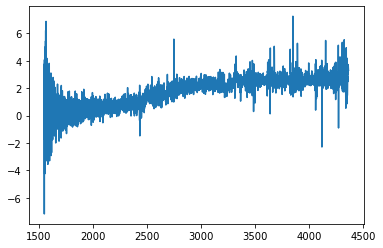

In [24]:
np.where(sigNoi_mean ==  sigNoi_mean.min() )
plt.plot(restWave[1294], X[1294])
plt.show()

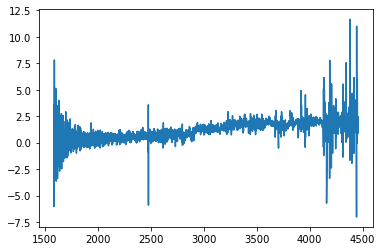

In [25]:
np.where(sigNoi_mean ==  sigNoi_mean.max() )
np.where(sigNoi_mean ==  sigNoi_mean.min() )
plt.plot(restWave[642], X[642])
plt.show()

In [26]:
redshift_li = []
# for item in eboss['Z_NOQSO'].values:
for item in eboss['DETECTION_Z'].values:
#     redshift_li.append(item[:4500].reshape(1, item[:4500].shape[0]))
    redshift_li.append(item)
redshift = np.array(redshift_li)

In [111]:
redshift.min(), redshift.max()

(0.7667207, 1.7131132)

In [27]:
zf_li = []
for item in eboss['Z_NOQSO'].values:
#     redshift_li.append(item[:4500].reshape(1, item[:4500].shape[0]))
    zf_li.append(item)
zf = np.array(zf_li)

In [28]:
redshift[:10], zf[:10]

(array([1.6161817, 1.0949216, 1.5093884, 1.4264305, 0.9411892, 1.4241962,
        1.3002117, 1.1615629, 0.9623109, 1.1896154], dtype=float32),
 array([0.502251, 0.466849, 0.613123, 0.641472, 0.468398, 0.513702,
        0.494892, 0.536801, 0.479044, 0.500057], dtype=float32))

In [71]:
plate[1], mjd[1], fiberid[0]

(3609, 55201, 306)

1 0.466849 1.0949216


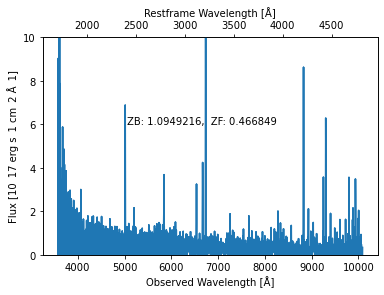

In [72]:
wanted_zf = 0.467
wanted_zb = 1.095
for i in range(1551):
    if ( math.isclose(zf[i], wanted_zf, abs_tol=0.001) and math.isclose(redshift[i], wanted_zb, abs_tol=0.001) ):
#     if ( math.isclose(redshift[i], wanted_zb, abs_tol=0.001)):
        print(i, zf[i], redshift[i])
        fig, axs = plt.subplots(1, 1)
        axs.set_xlabel('Observed Wavelength [Å]')
        axs.set_ylabel('Flux [10 17 erg s 1 cm 2 Å 1]')
        axs.plot(wave[i], X[i])
        axs.text(wave[i].max()/2, 6, 'ZB: '+str(redshift[i])+ ',  ZF: '+str(zf[i]))
        axs.set_ylim(0, 10)
        axes2 = axs.twiny()
        # axes2.set_xticks(axs.get_xticks()/(1+redshift[i]))
        axes2.set_xlabel('Restframe Wavelength [Å]')
        axes2.plot(restWave[i], X[i])
        fig.align_xlabels()


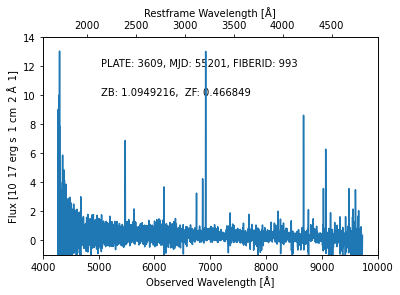

In [65]:
i = 1
fig, axs = plt.subplots(1, 1)
axs.set_xlabel('Observed Wavelength [Å]')
axs.set_ylabel('Flux [10 17 erg s 1 cm 2 Å 1]')
axs.plot(wave[i])
axs.text(wave[i].max()/2, 12, 'PLATE: '+str(plate[i])+ ', MJD: '+str(mjd[i])+', FIBERID: '+str(fiberid[i]))
axs.text(wave[i].max()/2, 10, 'ZB: '+str(redshift[i])+ ',  ZF: '+str(zf[i]))
axs.set_ylim(-1, 14)
axs.set_xlim(4000, 10000)
axes2 = axs.twiny()
# axes2.set_xticks(axs.get_xticks()/(1+redshift[i]))
axes2.set_xlabel('Restframe Wavelength [Å]')
axes2.plot(restWave[i], X[i])
# axes2.set_xlim(3710, 3750)
fig.align_xlabels()

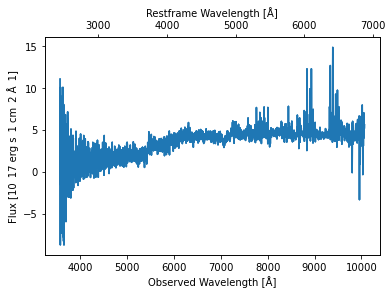

In [103]:
i= 20


In [23]:
restWave = np.zeros([1551, 4500])
for i in range(len(restWave)):
    restWave[i] = wave[i] / (1+redshift[i])
maskedWave = restWave.copy()

In [34]:
for i in range(1551):
    if redshift[i] == 0.283:
        plt.plot(restWave[i], X[i], label='De-redshift Spectra')
        plt.text(wave[i].max()/2, X[i].min(), 'Redshift: '+str(redshift[i]))
        plt.show()

In [64]:
# for i in range(1551):
#     if sigNoi_mean[i] < 0.38:
#         print(i)

In [55]:
# for i in range(1551):
#     if redshift[i] < 0.4:
#         print(i)

In [ ]:
# for i in range(6,7):
#     if sigNoi_mean[i] < 0.4:
#         plt.plot(restWave[i], X[i], zorder=2, color='k')
#         plt.text(restWave[i].max()/2, X[i].min(), 'Redshift: '+str(redshift[i]), bbox=dict(facecolor='white', alpha=0.4))
#         plt.title('RestFrame Wavelength '+ str(i))
#         for j in range(len(restWave[i])):
#             for k in range(len(waveLine)):
#                 plt.plot([restWave[i][j], restWave[i][j]], [X[i][j]-2, X[i].max()-1], 'b--', zorder=0)
#                 plt.text(restWave[i][j]-100, X[i].max(), str(waveLineName[k]))
#             for h in range(len(absLine)):
#                 plt.plot([restWave[i][j], restWave[i][j]], [X[i][j]-2, X[i].max()-1], 'c:', zorder=0)
#                 plt.text(restWave[i][j]-100, X[i].max(), str(absLineName[h]))
#         plt.show()
#         print(restWave[i].min())

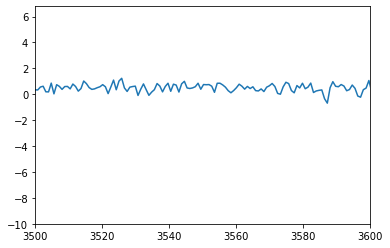

In [121]:
plt.plot(restWave[0], X[0])
# plt.xlim(restWave[0].max()/2, restWave[0].max())
plt.xlim(3500, 3600)
plt.show()

Set tolerance of 0.2-0.3


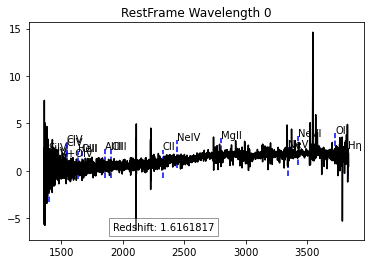

1361.85888671875


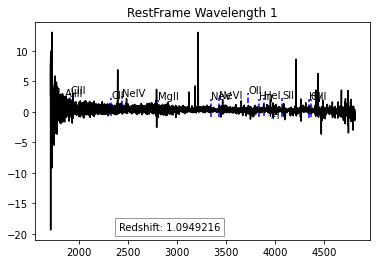

1708.5682373046875


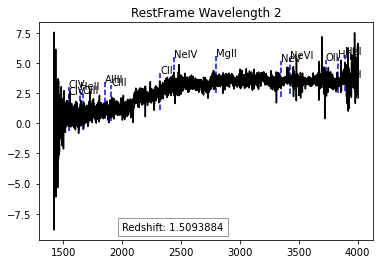

1420.797119140625


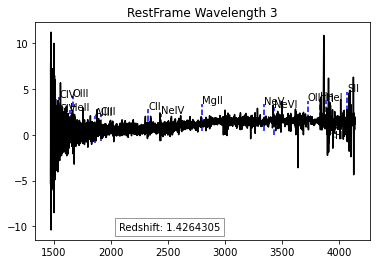

1469.7119140625


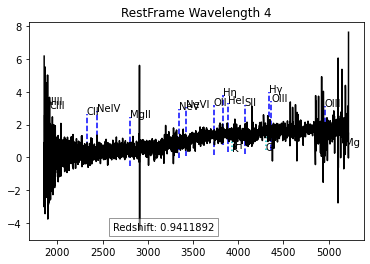

1852.815673828125


In [69]:
maskedFlux = X.copy()
for i in range(5):
#     if sigNoi_mean[i] < 0.4:
        plt.plot(restWave[i], X[i], zorder=2, color='k')
        plt.text(restWave[i].max()/2, X[i].min(), 'Redshift: '+str(redshift[i]), bbox=dict(facecolor='white', alpha=0.4))
        plt.title('RestFrame Wavelength '+ str(i))
        for j in range(len(restWave[i])):
            for k in range(len(waveLine)):
                if ( math.isclose(waveLine[k], restWave[i][j], abs_tol=0.3) ):
#                     plt.plot([restWave[i][j], restWave[i][j]], [X[i][j]-2, X[i].max()-1], 'b--', zorder=0)
#                     plt.text(restWave[i][j]-100, X[i].max(), str(waveLineName[k]))
                    plt.plot([waveLine[k], waveLine[k]], [X[i][j]-1, X[i][j].max()+2], 'b--', zorder=0)
                    plt.text(waveLine[k], X[i][j]+2, str(waveLineName[k]))
        #             maskedWave[i][j]= (restWave[i][j-1] + restWave[i][j+1]) / 2 
            for h in range(len(absLine)):
                if ( math.isclose(absLine[h], restWave[i][j], abs_tol=0.3) ):
                    plt.plot([restWave[i][j], restWave[i][j]], [X[i][j]-1, X[i][j].max()], 'c:', zorder=0)
                    plt.text(restWave[i][j], X[i][j]-1, str(absLineName[h]))

#         plt.xlim()
#         plt.xlim(X[i].max()-2, X[i].max())
#         plt.xlim(restWave[i].max()/2+3250, (restWave[i].max()/2)+3300)
#         plt.ylim(-1, 10)
#         plt.xlim(restWave[i].min()+2000, restWave[i].min()+2050)
        plt.show()
        print(restWave[i].min())

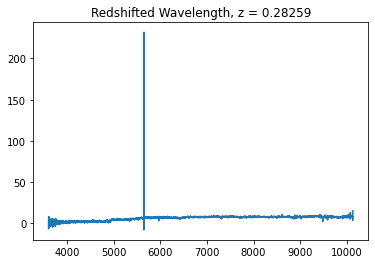

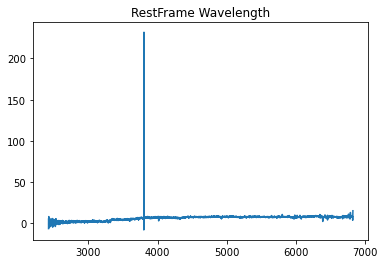

[ 3568.6177  3569.4385  3570.2617 ... 10050.788  10053.095  10055.413 ]
[2782.35253906 2782.99243164 2783.63427734 ... 7836.32177734 7838.12011719
 7839.92773438]


In [83]:

plt.plot(wave[2], X[2])
plt.title('Redshifted Wavelength, z = '+ str(redshift[0]))
plt.show()
plt.plot(restWave[2], X[2])
plt.title('RestFrame Wavelength')
plt.show()

print(wave[0])

print(restWave[0])

# for j in range(len(restWave[0])):
#     if (np.any(waveLine == restWave[0][j])):
#         print(restWave[0][j])


In [128]:
redshift

array([1.0406464, 1.0872176, 1.0642766, ..., 1.1800572, 1.6101638,
       1.5262003], dtype=float32)

### Emision Lines

In [43]:
lines = {1033.82:"OVI", 1215.67:"Ly"}

In [ ]:
if lines[]

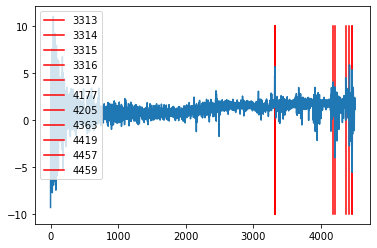

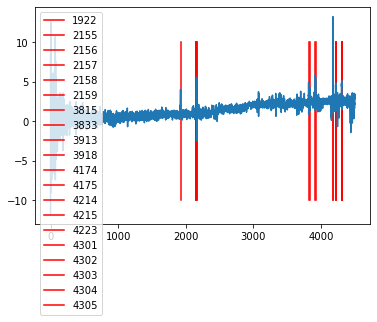

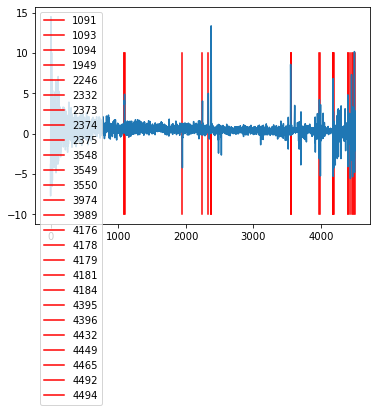

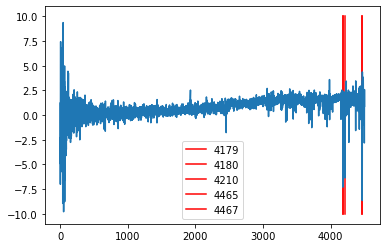

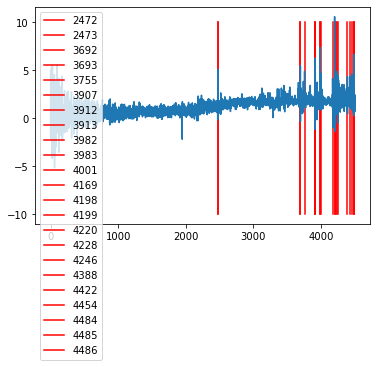

In [36]:
for i in range(5):
    for j in range(1000, 4500):
        if(np.abs(X[i][j])>4):
            plt.plot([j, j], [-10, 10], c='red', label=j)
    plt.plot(X[i])
    plt.legend()
    plt.show()

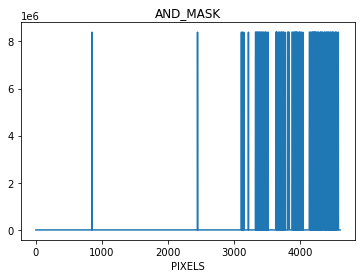

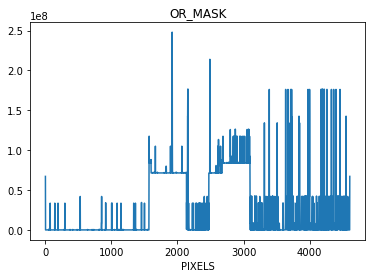

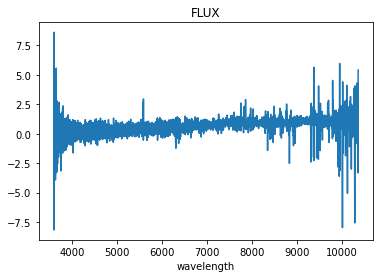

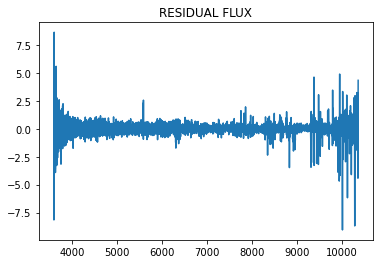

In [14]:
a = eboss.sample(1551)['AND_MASK'][1550]
b = eboss.sample(1551)['OR_MASK'][1550]
c = eboss.sample(1551)['FLUX'][1550]
c1 = eboss.sample(1551)['WAVE'][1550]
d = eboss.sample(1551)['RESIDUAL_FLUX'][1550]
plt.title('AND_MASK')
plt.xlabel('PIXELS')
plt.plot(a, label='AND_MASK')
plt.show()
plt.title('OR_MASK')
plt.xlabel('PIXELS')
plt.plot(b, label='OR_MASK')

plt.show()
plt.title('FLUX')
plt.xlabel('wavelength')
plt.plot(c1, c, label='FLUX')
plt.show()
plt.title('RESIDUAL FLUX')
plt.plot(c1, d)
plt.show()

# plt.ylim(-10, 15)
plt.show()

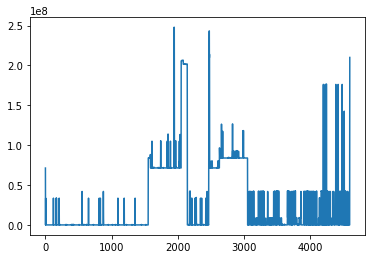

In [78]:

plt.plot(b)
plt.show()

In [84]:
AND_MASK = []

for item in eboss.sample(1551)['AND_MASK'].values:
    #print(item.shape)
    AND_MASK.append(item[:4500].reshape(1, item[:4500].shape[0]))
    #print(item.reshape(1, item.shape[0]).shape)
flux_sample = np.concatenate((AND_MASK))
X_AND_MASK = flux_sample.copy()
X_AND_MASK_mean=X_AND_MASK.mean(axis=0)

In [85]:
OR_MASK = []

for item in eboss.sample(1551)['OR_MASK'].values:
    #print(item.shape)
    OR_MASK.append(item[:4500].reshape(1, item[:4500].shape[0]))
    #print(item.reshape(1, item.shape[0]).shape)
flux_sample = np.concatenate((OR_MASK))
X_OR_MASK = flux_sample.copy()
X_OR_MASK_mean=X_OR_MASK.mean(axis=0)

In [114]:
flux_re = []

for item in eboss.sample(25)['RESIDUAL_FLUX'].values:
    #print(item.shape)
    flux_re.append(item[:4500].reshape(1, item[:4500].shape[0]))
    #print(item.reshape(1, item.shape[0]).shape)
flux_sample_re = np.concatenate((flux_re))
Xre = flux_sample_re.copy()

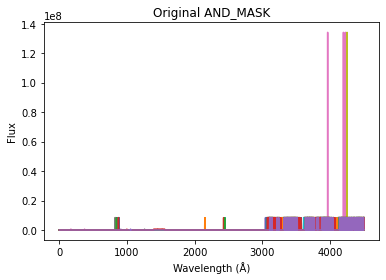

In [82]:
for i in range(25):
    plt.plot(X_AND_MASK[i])
#     plt.plot(pca_comps[0])
    plt.title('Original AND_MASK')
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Å)')
#     plt.ylim(-10, 15)
# plt.plot(X_AND_MASK_mean, c='b', label='Average')
# plt.legend()
plt.show()

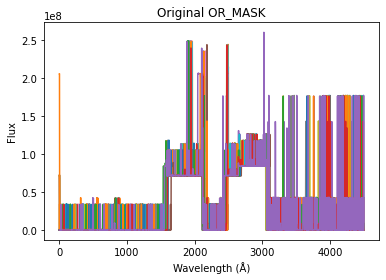

In [86]:
for i in range(25):
    plt.plot(X_OR_MASK[i])
#     plt.plot(pca_comps[0])
    plt.title('Original OR_MASK')
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Å)')
#     plt.ylim(-10, 15)
# plt.plot(X_AND_MASK_mean, c='b', label='Average')
# plt.legend()
plt.show()

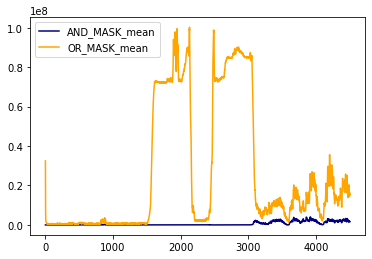

In [89]:
plt.plot(X_AND_MASK_mean, label='AND_MASK_mean', c='navy')
plt.plot(X_OR_MASK_mean, label='OR_MASK_mean', c='orange')
plt.legend()
plt.show()

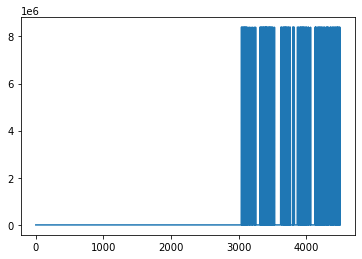

In [71]:
plt.plot(X_AND_MASK[0], zorder=2)
plt.show()

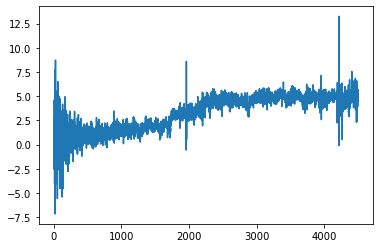

In [73]:
plt.plot(X[0], zorder=0)
plt.show()

In [270]:
def init_pca(X, n_comp):
    pca = PCA(n_comp, svd_solver='full')
    Xproj =pca.fit_transform(X)
    pca_comps = pca.components_
    return pca, Xproj, pca_comps

In [271]:
#Eigenimages
def show_eigen_spectra(Xproj, pca_comps, let_idx=0, dim = 16):
    fig, axes = plt.subplots(1, pca_comps.shape[0])
    fig.set_size_inches(30, 5)
    coeffs = (Xproj[let_idx])
    for i in range(pca_comps.shape[0]):    
#         plt.plot((coeffs[i]*pca_comps[i]))
#         plt.title(str(i)+'. Coeff: '+str(coeffs[i])) 
#         print('Eigen Spectra '+str(i),'Coeff: '+str(coeffs[i]))
#         plt.show()
        axes[i].plot(coeffs[i]*pca_comps[i])
        axes[i].axis('off')
    print(let_idx)
    print('Coeffs', coeffs)    
    plt.show()

In [272]:
def show_pca_spectra(Xproj, pca_comps, let_idx = 0, dim = 16):
    show_eigen_spectra(Xproj, pca_comps, let_idx)
    rec_let = np.zeros((1, 4500))
    coeffs = (Xproj[let_idx])
    ims = []
    fig = plt.figure()
    for i in range(pca_comps.shape[0]):
        #linear combination
        rec_let += coeffs[i]*pca_comps[i]#.reshape((1, 4500))
#         ax = plt.subplot(111)
#         ax.axis('off')
#         ax.imshow(rec_let)
#         plt.show()
#     fig, ax = plt.subplot(1, 1)
    ax = plt.subplot(111)
    ax.axis('off')
    ax.imshow(rec_let)
    plt.show()

In [273]:
def rec_letFun(Xproj, pca_comps, let_idx, dim = 16):
    rec_let = np.zeros((1, 4500))
    coeffs = (Xproj[let_idx])
    for i in range(pca_comps.shape[0]):
        #linear combination
        rec_let += coeffs[i]*pca_comps[i].reshape((1, 4500))
    return rec_let+ pca.mean_

In [283]:
import IPython
n_comp = 25
pca, Xproj, pca_comps = init_pca(X, n_comp)

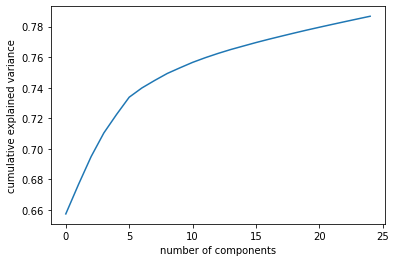

In [284]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.plot([0, 1551], [0.9, 0.9], '--')
# plt.plot([0, 1551], [1, 1], '--')
# plt.ylim(0.85, 1.01)
# plt.xlim(0,200)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [285]:
X.mean(axis=0)

array([1.0788976 , 0.47067258, 0.7660238 , ..., 2.4444497 , 2.3751266 ,
       2.2505891 ], dtype=float32)

In [65]:
# X_new = X.T
# rec_mean = np.zeros((1, 4500))

# for i in range(4500):
#     temp=0
#     for j in range(25):
#         temp+=X_new[i][j]/25
#     rec_mean[0][i]=temp
# Xmean = rec_mean[0]

In [286]:
Xmean=X.mean(axis=0)

In [287]:
PCAmean = pca.mean_ #== zeroth component

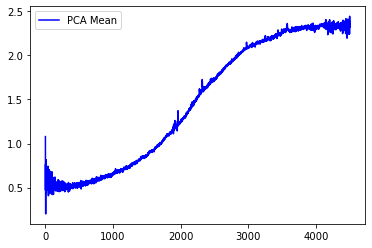

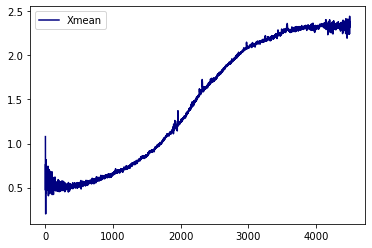

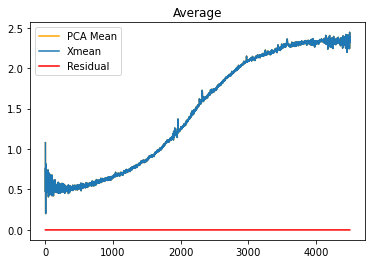

In [288]:
plt.plot(PCAmean,label='PCA Mean', c='blue')
plt.legend()
plt.show()


plt.plot(Xmean, label='Xmean', c='navy')
plt.legend()
plt.show()
plt.title('Average')
plt.plot(PCAmean,label='PCA Mean', c='orange')
plt.plot(Xmean, label='Xmean')
plt.plot(PCAmean-Xmean, c='red', label='Residual')
plt.legend()
plt.show()

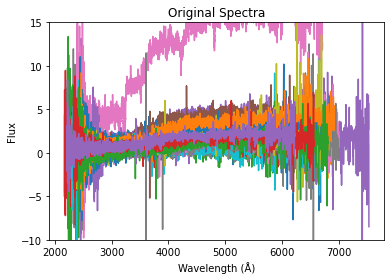

In [293]:
for i in range(25):
    plt.plot(restWave[i], X[i])
#     plt.plot(pca_comps[0])
    plt.title('Original Spectra')
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Å)')
    plt.ylim(-10, 15)
# plt.plot(Xmean, c='b', label='Average')
# plt.legend()
plt.show()

In [12]:
residual = np.zeros((1551, 4500))
for i in range(1547,1551):
    rec_let = rec_letFun(Xproj, pca_comps, let_idx=i)
    residual[i] = ((X[i])-(rec_let[0]))/(4500*1551)
    window_size = 100
    residual_smooth = np.convolve(residual[i], np.ones((window_size,))/window_size, mode='same')    
   
    plt.title('Spectra '+str(i))
    plt.plot(wave[i], X[i], label='Original Spectra', c='blue')    
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Å)')
    plt.legend()
    plt.show()
    
    plt.plot(wave[i], rec_let[0], label='Reconstructed Spectra', color='navy')
    plt.title('Reconstructed Spectra')
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Å)')
    plt.legend()
    plt.show()
    
    
    plt.plot(wave[i], residual[i], label='Residual Spectra', color='gray', zorder=0)
    plt.plot(wave[i], residual_smooth, label='Residual Spectra Smooth', color='black', zorder=2)
   
    plt.title('Residual Spectra ')
    plt.hlines(0, 0, 4500, colors='r', zorder=1)
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Å)')
    plt.legend()
    plt.ylim(residual[i].min(), residual[i].max())
    plt.show()
    
    plt.title('AND_MASK')
    plt.plot(X_AND_MASK[i], label='AND_Mask')
    plt.show()
    
    plt.title('OR_MASK')
    plt.plot(X_OR_MASK[i], label='AND_Mask')
    plt.show()
    
    
    
    
    plt.plot(residual_smooth, label='Residual Spectra Smooth', color='black', zorder=2)
    plt.title('Residual Spectra Smooth')
    plt.hlines(0, 0, 4500, colors='r', zorder=1)
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Å)')
    plt.legend()
    plt.ylim(residual_smooth.min(), residual_smooth.max())
    plt.show()

               

NameError: name 'rec_letFun' is not defined

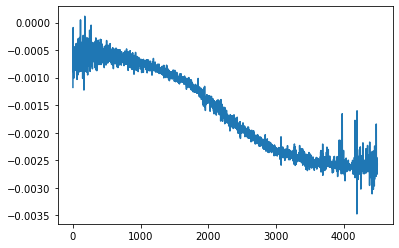

In [256]:
plt.plot(residual[0])
plt.show()

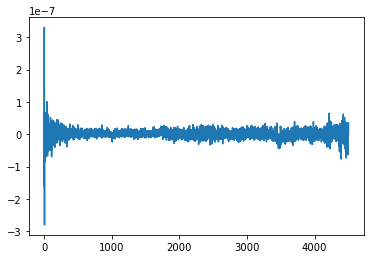

In [222]:

for i in range(4500):
    temp=0
    for j in range(25):
        temp+=residual[j][i]/4500
    rec_mean[0][i]=temp
#     (rec_tot[0][i]+rec_tot[20][i]+rec_tot[24][i])/200
# plt.plot(rec_tot[0], label='Mean')
average_residual = rec_mean[0]
# plt.plot(average_residual, label='Mean', c='orange')
# # plt.plot(residual[5], label='residual', zorder=2)
# # plt.plot(PCAmean-rec_average, label='PCA Mean', zorder=2)
# plt.title('Average Residual')
# plt.ylabel('Flux')
# plt.xlabel('Wavelength (Å)')
# # plt.plot(pca_comps[0], label='0th')
# # plt.ylim(-0.02, 0.05)
# plt.legend()
# plt.show()
plt.plot(average_residual)
plt.show()


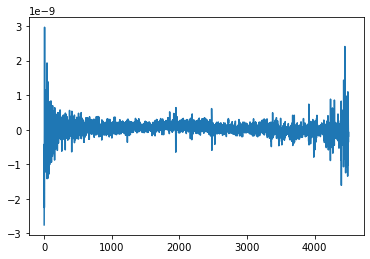

In [224]:
plt.plot(residual[2])
plt.show()

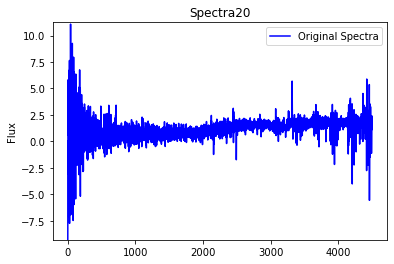

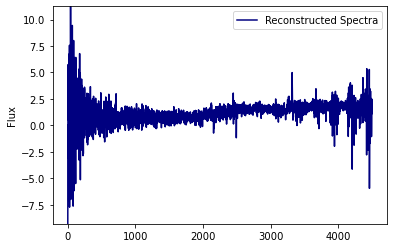

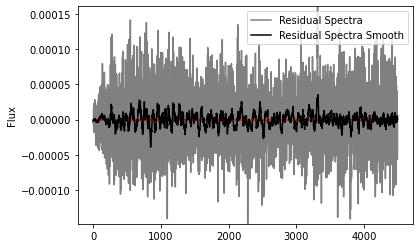

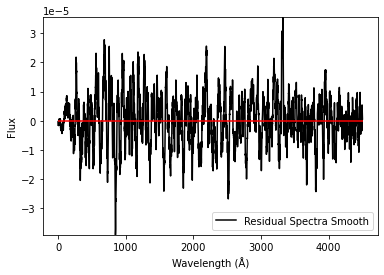

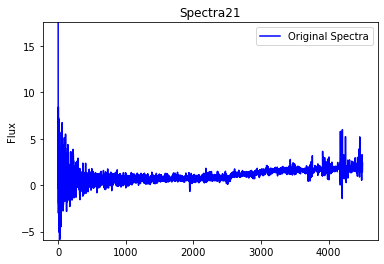

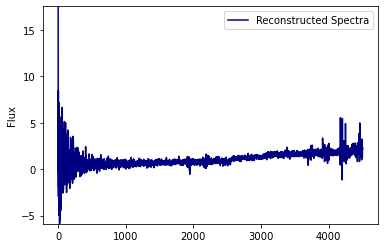

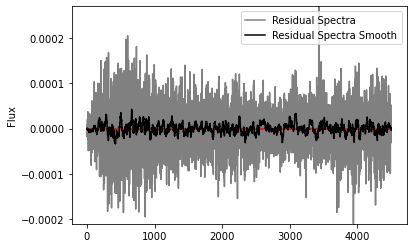

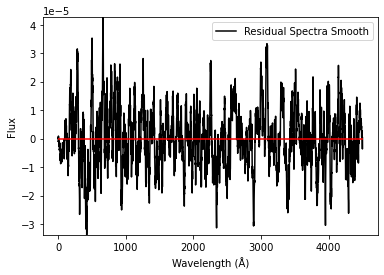

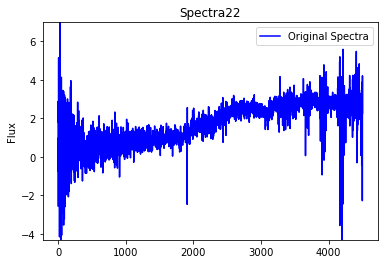

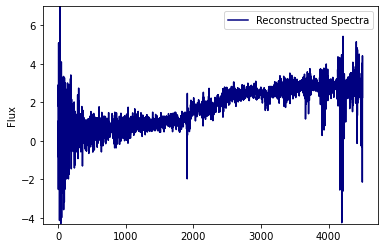

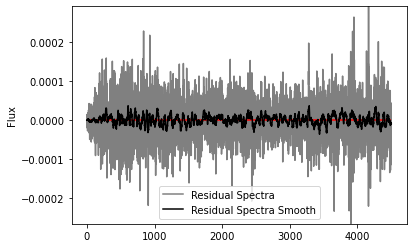

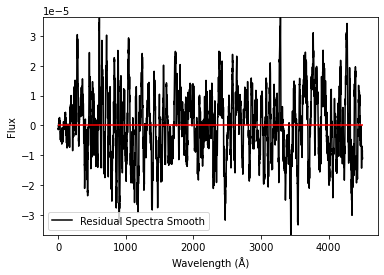

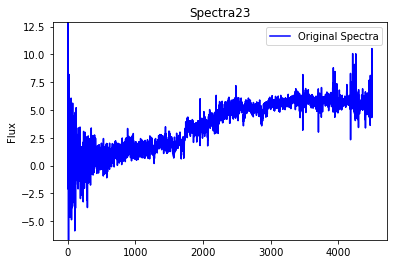

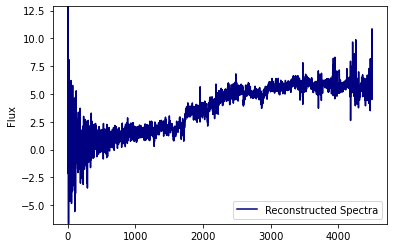

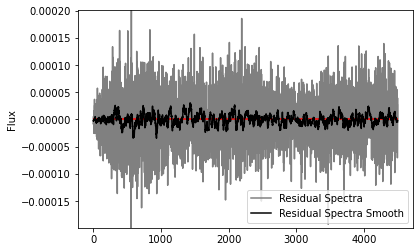

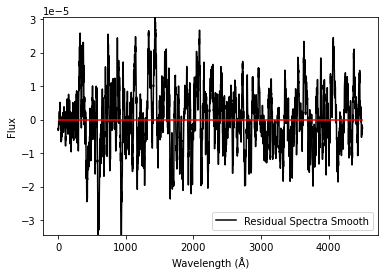

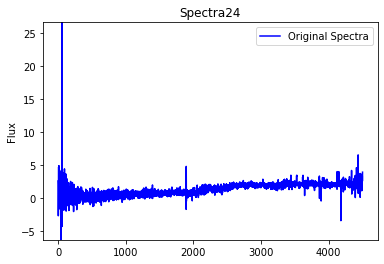

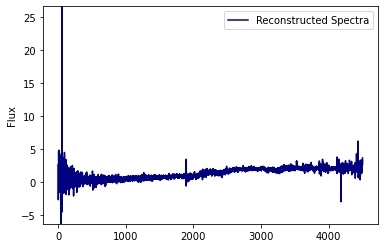

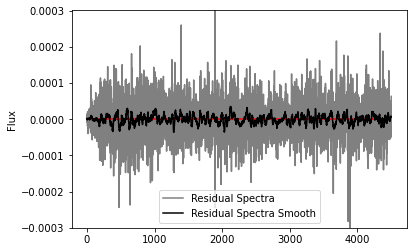

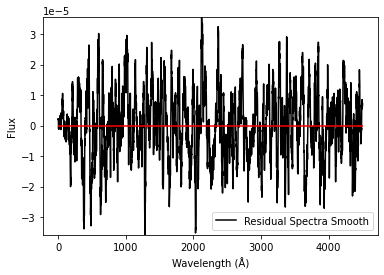

In [279]:
%matplotlib inline
rec_tot = np.zeros((1551, 4500))
residual = np.zeros((1551, 4500))
# rec_let = show_pca_spectra(Xproj, pca_comps, let_idx = 1)
for i in range(20, 25):
    
#     show_pca_spectra(Xproj, pca_comps, let_idx = i)
    
    rec_let = rec_letFun(Xproj, pca_comps, let_idx=i)
    rec_tot[i]=rec_let[0]
#     rec_tot.append(rec_let[0])
#     rec_mean.append(rec_let[0]/(i+1))
    plt.title('Spectra'+str(i))
    plt.plot(X[i], label='Original Spectra', c='blue')
#     plt.plot(Xmean, label='Mean')
    
    plt.ylabel('Flux')
#     plt.xlabel('Wavelength (Å)')
#     plt.ylim(-15, 20)
    plt.ylim(rec_let[0].min(), rec_let[0].max())
    plt.legend()
    plt.show()
    
    
    plt.plot(rec_let[0]+pca_comps[0], label='Reconstructed Spectra', color='navy')
#     plt.plot(Xmean, label='Mean')
#     plt.title('Reconstructed Spectra')
    plt.ylabel('Flux')
#     plt.xlabel('Wavelength (Å)')
    plt.ylim(rec_let[0].min(), rec_let[0].max())
#     plt.ylim(X[i].min(), X[i].max())
    plt.legend()
    plt.show()
    
   #     for _ in range(len(X[i])):
#         residual.append(((X[i][_]) - (rec_let[0][_]))/2)
#     plt.plot(residual)
#     for j in range(4500):
# # #         if X[i][j]<0:
            
#         if X[i][j]<rec_let[0][j]:
#             residual[j]=(rec_let[0][j]-X[i][j])
#         if X[i][j]>rec_let[0][j]:
#             residual[j]=(X[i][j]-rec_let[0][j])
#         if X[i]<0:
#                 residual = residual/-1
    
    
    residual[i] = ((X[i])-(rec_let[0]))/4500
    window_size = 25
    residual_smooth = np.convolve(residual[i], np.ones((window_size,))/window_size, mode='same')
#     for j in range(4500):
#         if X[i][j]<0:
#             residual[j]=residual[j]/-1
#     if(X[i]<0):
#         residual = residual/-1
#     if (rec_let[0]<0):
#         residual = residual/-1
    plt.plot(residual[i], label='Residual Spectra', color='gray', zorder=0)
#     plt.plot(average_residual, label='Average')
    plt.plot(residual_smooth, label='Residual Spectra Smooth', color='black', zorder=2)
#     plt.title('Residual Spectra ')
#     plt.plot( , label='Mean')
    plt.hlines(0, 0, 4500, colors='r', zorder=1)
    plt.ylabel('Flux')
#     plt.xlabel('Wavelength (Å)')
    plt.legend()
#     plt.ylim(-15, 20)
    plt.ylim(residual[i].min(), residual[i].max())
    plt.show()
    
    #zoom version
#     plt.plot(residual, label='Residual Spectra Zoom', zorder=0, color='gray')
    plt.plot(residual_smooth, label='Residual Spectra Smooth', color='black', zorder=0)
    plt.hlines(0, 0, 4500, colors='r', zorder=2)
#     plt.plot(Xmean, label='Mean')
#     plt.title('Residual Spectra zoom')
    plt.ylabel('Flux')
    plt.xlabel('Wavelength (Å)')
    plt.legend()
#     plt.ylim(-15, 20)
    plt.ylim(residual_smooth.min(), residual_smooth.max())

    plt.show()
#     plt.plot(Xre[i])
#     plt.title('Original Residual Flux ')
#     plt.ylim(rec_let[0].min(), rec_let[0].max())
#     plt.show()

In [124]:
residual.shape

(25, 4500)

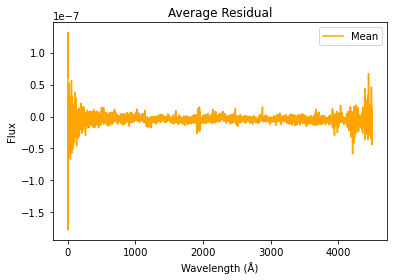

In [123]:

for i in range(4500):
    temp=0
    for j in range(25):
        temp+=residual[j][i]/
    rec_mean[0][i]=temp*25
#     (rec_tot[0][i]+rec_tot[20][i]+rec_tot[24][i])/200
# plt.plot(rec_tot[0], label='Mean')
average_residual = rec_mean[0]
plt.plot(average_residual, label='Mean', c='orange')
# plt.plot(PCAmean, label='PCA Mean', zorder=2)
# plt.plot(PCAmean-rec_average, label='PCA Mean', zorder=2)
plt.title('Average Residual')
plt.ylabel('Flux')
plt.xlabel('Wavelength (Å)')
# plt.plot(pca_comps[0], label='0th')
# plt.ylim(-0.02, 0.05)
plt.legend()
plt.show()

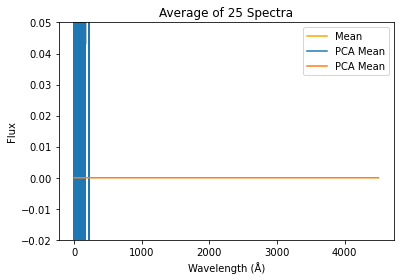

In [102]:
rec_tot = np.zeros((25, 4500))
rec_mean = np.zeros((1, 4500))
for i in range(25):
    rec = rec_letFun(Xproj, pca_comps, let_idx=i)
    rec_tot[i]=rec[0]

for i in range(4500):
    temp=0
    for j in range(25):
        temp+=rec_tot[j][i]/25
    rec_mean[0][i]=temp
#     (rec_tot[0][i]+rec_tot[20][i]+rec_tot[24][i])/200
# plt.plot(rec_tot[0], label='Mean')
rec_average = rec_mean[0]

# X_new = X.T
# for i in range(4500):
#     temp=0
#     for j in range(25):
#         temp+=X_new[i][j]/25
#     rec_mean[0][i]=temp
# #     (rec_tot[0][i]+rec_tot[20][i]+rec_tot[24][i])/200
# # plt.plot(rec_tot[0], label='Mean')
# rec_average = rec_mean[0]

plt.plot(rec_average, label='Mean', c='orange')
plt.plot(PCAmean, label='PCA Mean', zorder=2)
plt.plot(PCAmean-rec_average, label='PCA Mean', zorder=2)
plt.title('Average of 25 Spectra')
plt.ylabel('Flux')
plt.xlabel('Wavelength (Å)')
# plt.plot(pca_comps[0], label='0th')
plt.ylim(-0.02, 0.05)
plt.legend()
plt.show()


## Handwritten digits

In [11]:
'''Loading handwritten digit data'''
from sklearn.datasets import load_digits
dig_data = load_digits()
dig_img = dig_data.images
Xdig = dig_data.data
digits = dig_data.target

In [233]:
import IPython
n_comp = 64
pca, Xproj, pca_comps = init_pca(Xdig, n_comp)

In [234]:
print("Percentage of variance explained by the first {:d} components: \n".format(n_comp), \
      pca.explained_variance_ratio_)
print("Total variance (sum of all n_comp percentage of variance): \n"+str(np.sum(pca.explained_variance_ratio_)))



Percentage of variance explained by the first 64 components: 
 [1.48905936e-01 1.36187712e-01 1.17945938e-01 8.40997942e-02
 5.78241466e-02 4.91691032e-02 4.31598701e-02 3.66137258e-02
 3.35324810e-02 3.07880621e-02 2.37234084e-02 2.27269657e-02
 1.82186331e-02 1.77385494e-02 1.46710109e-02 1.40971560e-02
 1.31858920e-02 1.24813782e-02 1.01771796e-02 9.05617439e-03
 8.89538461e-03 7.97123157e-03 7.67493255e-03 7.22903569e-03
 6.95888851e-03 5.96081458e-03 5.75614688e-03 5.15157582e-03
 4.89539777e-03 4.28887968e-03 3.73606048e-03 3.53274223e-03
 3.36683986e-03 3.28029851e-03 3.08320884e-03 2.93778629e-03
 2.56588609e-03 2.27742397e-03 2.22277922e-03 2.11430393e-03
 1.89909062e-03 1.58652907e-03 1.51159934e-03 1.40578764e-03
 1.16622290e-03 1.07492521e-03 9.64053065e-04 7.74630271e-04
 5.57211553e-04 4.04330693e-04 2.09916327e-04 8.24797098e-05
 5.25149980e-05 5.05243719e-05 3.29961363e-05 1.24365445e-05
 7.04827911e-06 3.01432139e-06 1.06230800e-06 5.50074587e-07
 3.42905702e-07 9.5068

In [ ]:
noise = 

In [41]:
def rec_letFunDig(Xproj, pca_comps, let_idx, dim = 16):
    rec_let = np.zeros((8, 8))
    coeffs = (Xproj[let_idx])
    for i in range(pca_comps.shape[0]):
        #linear combination
        rec_let += coeffs[i]*pca_comps[i].reshape((8, 8))
    return rec_let + pca.mean_.reshape((8, 8))

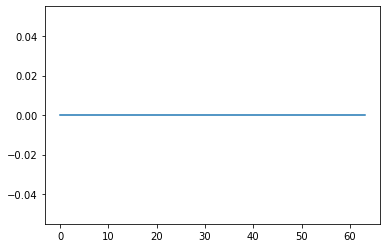

In [57]:
zero_range = np.zeros(64)
plt.plot(zero_range)
plt.show()

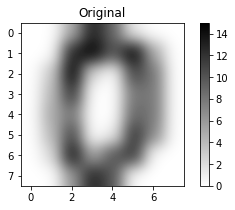

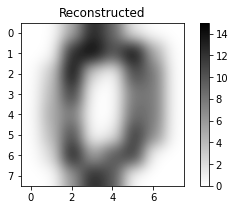

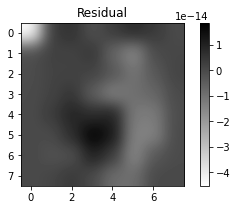

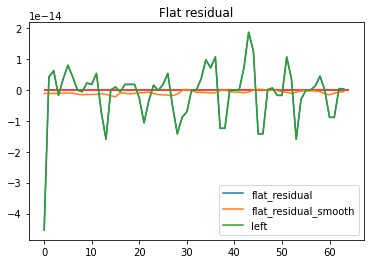

In [58]:
for i in range(1):
    idx_select = i
    plt.figure(figsize=(6,3))
    plt.imshow(dig_img[idx_select], cmap = plt.cm.gray_r, interpolation='Gaussian')
    plt.colorbar()
    plt.title('Original')
    plt.show()
    
    dig_im_rec_new = rec_letFunDig(Xproj, pca_comps, let_idx = idx_select, dim = 16)
    plt.figure(figsize=(6,3))
    plt.imshow(dig_im_rec_new, cmap = plt.cm.gray_r, interpolation='Gaussian')
    plt.colorbar()
    plt.title('Reconstructed')
    plt.show()
    
    residual = dig_img[i]-dig_im_rec_new
    
    plt.figure(figsize=(6,3))
    plt.imshow(residual, cmap = plt.cm.gray_r, interpolation='Gaussian')
    plt.colorbar()
    plt.title('Residual')
    plt.show()
    
    flat_residual = residual.ravel()
    flat_residual.shape
#     left = flat_residual -  np.zeros(64)
    window_size = 30
    residual_smooth = np.convolve(flat_residual, np.ones((window_size,))/window_size, mode='same')
    plt.plot(flat_residual, label='flat_residual')
    plt.plot(residual_smooth, label='flat_residual_smooth')
#     plt.plot(left, label='left')
    plt.hlines(0, 0, 64, colors='r', zorder=2)
    plt.title('Flat residual')
#     plt.ylim(residual_smooth.min()*2, residual_smooth.max()*2)
    plt.legend()
    plt.show()
    

In [55]:
for i in range(7:8):
    dig_im_rec_new = rec_letFunDig(Xproj, pca_comps, let_idx = i, dim = 16)
    residual = dig_img[i]-dig_im_rec_new
    
    flat_residual = residual.ravel()
    flat_residual.shape
    window_size = 64
    residual_smooth = np.convolve(flat_residual, np.ones((window_size,))/window_size, mode='same')
    plt.plot(flat_residual, label='flat_residual')
    plt.plot(residual_smooth, label='flat_residual_smooth')
    plt.title('Flat residual')
#     plt.ylim(flat_residual.min()/2, flat_residual.max()/2)
    plt.legend()
    plt.show()

SyntaxError: invalid syntax (<ipython-input-55-f87e9a589119>, line 1)

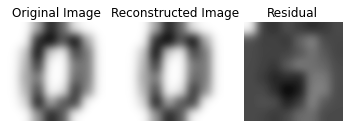

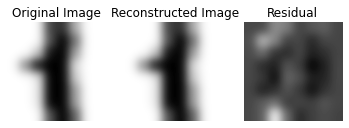

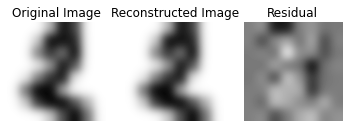

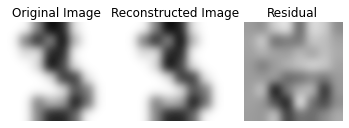

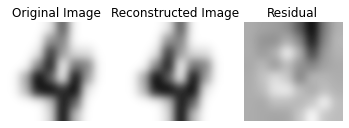

In [17]:
for i in range(5):
    dig = i
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (6, 3))
    dig_im_rec_new = rec_letFunDig(Xproj, pca_comps, let_idx = dig, dim = 16)
    #OG Image
    ax0.imshow(dig_img[dig], cmap='binary', interpolation='Gaussian')

    #Reconstructed Image
    ax1.imshow(dig_im_rec_new, cmap='binary', interpolation='Gaussian')

    #Residual
    ax2.imshow(dig_img[dig]-dig_im_rec_new, cmap='binary', interpolation='Gaussian')

    # To turn off grid (under seaborn, the default for grid is on.)

    ax1.set_title('Reconstructed Image')
    ax1.grid(False)
    ax1.axis('off')

    ax0.set_title('Original Image')
    ax0.grid(False)
    ax0.axis('off')

    ax2.set_title('Residual')
    ax2.grid(False)
    ax2.axis('off')
    
    plt.show()

## Mask

#### have to redshift wavelenght first because every galaxy has different redshift

https://classic.sdss.org/dr7/algorithms/speclinefits.html#linelist
http://classic.sdss.org/dr6/algorithms/linestable.html
